<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Cat-vs-Dog-Classification/blob/main/cat_vs_dog_classification_%5Bsimple_cnn_architecture%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Cat vs Dog Classification [Simple CNN Architecture]** 

We will use the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. 



In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Downloading the dataset from its original source. 
The `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-06-29 18:41:55--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.72.44.106, 2600:1413:b000:382::e59, 2600:1413:b000:39b::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.72.44.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   257MB/s    in 3.1s    

2022-06-29 18:41:58 (257 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



The images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, one for dogs and one for cats.

In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


So, we will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. 

In [4]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


def create_train_val_dirs(root_path):
  
  # os.makedirs() will create directories with intermediate subdirectories
  # os.path.join() will append the new directories to the root_path parameter

  os.makedirs(os.path.join(root_dir,"training"))
  os.makedirs(os.path.join(f"{root_dir}/training", "dogs"))
  os.makedirs(os.path.join(f"{root_dir}/training", "cats"))
  os.makedirs(os.path.join(root_dir,"validation"))
  os.makedirs(os.path.join(f"{root_dir}/validation", "dogs"))
  os.makedirs(os.path.join(f"{root_dir}/validation", "cats"))

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
# Testing create_train_val_dirs() function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [6]:
#  Spliting the whole data into train and test set
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    # SOURCE_DIR (string): directory path containing the images
    # TRAINING_DIR (string): directory path to be used for training
    # VALIDATION_DIR (string): directory path to be used for validation
    # SPLIT_SIZE (float): proportion of the dataset to be used for training
    

  processed_data = []
  
  for filename in os.listdir(SOURCE_DIR) :
    file = SOURCE_DIR + filename
    if os.path.getsize(file) > 0 :
      processed_data.append(filename)
    else :
      print(f"{filename} is zero length, so ignoring.")

  randomized_data = random.sample(processed_data, len(processed_data))

  training_length = int(len(randomized_data)*SPLIT_SIZE)
  validation_length = int(len(randomized_data) - training_length)

  training_data = randomized_data[:training_length]
  validation_data = randomized_data[-validation_length:]


  for filename in training_data :
    present_file = SOURCE_DIR + filename
    destination = TRAINING_DIR + filename
    copyfile(present_file, destination)


  for filename in validation_data :
    present_file = SOURCE_DIR + filename
    destination = VALIDATION_DIR + filename
    copyfile(present_file, destination)


In [7]:
# Testing split_data function

# Defining paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case running this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# proportion of images used for training
split_size = .9

# Messages about zero length images will be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [8]:
#  Creating the training and validation data generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):


  # Instantiating the ImageDataGenerator class also normalization
  train_datagen = ImageDataGenerator(rescale=1.0/255)

  # Passing in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode="binary",
                                                      target_size=(150, 150))

  
  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=100,
                                                                class_mode="binary",
                                                                target_size=(150, 150))


  return train_generator, validation_generator

In [9]:
# Testing the generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation = "relu", input_shape = (150,150,3)),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation = "relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation = "relu"),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = "relu"),
      tf.keras.layers.Dense(1, activation = "sigmoid")
  ])

  from tensorflow.keras.optimizers import RMSprop

  model.compile(optimizer = RMSprop(learning_rate = 0.001),
                loss = "binary_crossentropy",
                metrics = ['accuracy']) 
    

  return model

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy') > 0.98):
      print("\nAccuracy is higher than 99% so canceling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
model = create_model()

# Training the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/20
 74/225 [========>.....................] - ETA: 42s - loss: 0.7943 - accuracy: 0.5853

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 72s 319ms/step - loss: 0.6643 - accuracy: 0.6501 - val_loss: 0.5244 - val_accuracy: 0.7424
Epoch 2/20
225/225 [==============================] - 71s 314ms/step - loss: 0.5103 - accuracy: 0.7496 - val_loss: 0.4683 - val_accuracy: 0.7804
Epoch 3/20
225/225 [==============================] - 71s 317ms/step - loss: 0.4322 - accuracy: 0.7989 - val_loss: 0.4839 - val_accuracy: 0.7616
Epoch 4/20
225/225 [==============================] - 70s 312ms/step - loss: 0.3632 - accuracy: 0.8363 - val_loss: 0.4039 - val_accuracy: 0.8176
Epoch 5/20
225/225 [==============================] - 70s 312ms/step - loss: 0.3014 - accuracy: 0.8715 - val_loss: 0.4154 - val_accuracy: 0.8216
Epoch 6/20
225/225 [==============================] - 71s 316ms/step - loss: 0.2263 - accuracy: 0.9076 - val_loss: 0.4677 - val_accuracy: 0.8276
Epoch 7/20
225/225 [==============================] - 70s 312ms/step - loss: 0.1534 - accuracy: 0.9401 - val_loss: 0.5114 - val_accuracy: 0.8

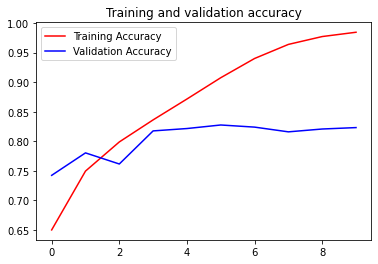

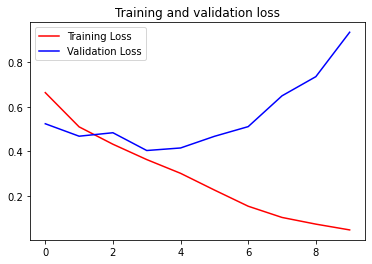

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label= "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label= "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label= "Training Loss")
plt.plot(epochs, val_loss, 'b', label= "Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggling with new data. 
